In [1]:
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from transformers import ViTForImageClassification, AutoProcessor
from pathlib import Path
from torchvision.transforms import ToPILImage

import sys; sys.path.append("../src/")
from stability import soft_stability_rate
from models import MaskedImageClassifier, CertifiedMuSImageClassifier
from image_utils import load_images_from_directory
from explanations import \
    get_lime_for_image, get_shap_for_image, get_intgrad_for_image, get_mfaba_for_image

device = "cuda" if torch.cuda.is_available() else "cpu"

/opt/conda/envs/rapids/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/envs/rapids/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may hav

In [2]:
processor = AutoProcessor.from_pretrained('google/vit-base-patch16-224')

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [3]:
# Load images; they will be ordered the same every time.
images = load_images_from_directory("/shared_data0/helenjin/imagenet-sample-images/")
# images = images[:20]
images = torch.tensor([processor(ToPILImage()(img))['pixel_values'] for img in images]).squeeze()
print(images.shape)

torch.Size([1000, 3, 224, 224])


In [4]:
# Load the model. This should be our custom fine-tuned models later!
raw_vit = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")
raw_vit.eval().to(device);

In [5]:
wrapped_vit = MaskedImageClassifier(raw_vit)
wrapped_vit.eval().to(device);

## Explanations take a while to generate, so we recommend using the cached version

In [6]:
# Generating explanations is expensive, so we'll cache things as needed
use_cache = True # Set to false if you wanna do it from scratch
cache_dir = Path("_cache")
lime_cache_file = cache_dir / "vit_lime.pt"
shap_cache_file = cache_dir / "vit_shap.pt"
intgrad_cache_file = cache_dir / "vit_intgrad.pt"
mfaba_cache_file = cache_dir / "vit_mfaba.pt"
cache_dir.mkdir(parents=True, exist_ok=True)

In [7]:
return_verbose = True

if return_verbose:
    cache_dir_full = Path("_cache/full_expln_output")
    cache_dir_full.mkdir(parents=True, exist_ok=True)
    
    cache_dir_attrs = Path("_cache/attrs")
    cache_dir_attrs.mkdir(parents=True, exist_ok=True)

In [8]:
# return_verbose = False

In [9]:
if lime_cache_file.exists() and use_cache:
    lime_explanations = torch.load(lime_cache_file)
else:
    print("Running LIME")
    if return_verbose:
        print("Saving everything")
        lime_explanations = []
        for i, img in enumerate(tqdm(images)):
            lime_expln_alpha, lime_expln, lime_expln_attrs = get_lime_for_image(wrapped_vit, img, return_verbose=True)
            torch.save(lime_expln, cache_dir_full / f'vit_lime_img{i}.pt')
            torch.save(lime_expln_attrs, cache_dir_attrs / f'vit_lime_img{i}.pt')
            lime_explanations.append(lime_expln_alpha)
        lime_explanations = torch.stack(lime_explanations)
    else:
        print("Saving just masked explanations")
        lime_explanations = torch.stack([get_lime_for_image(wrapped_vit, img) for img in tqdm(images)])
    lime_explanations = torch.squeeze(lime_explanations)
    torch.save(lime_explanations, lime_cache_file)
print("LIME explanations", lime_explanations.shape)

LIME explanations torch.Size([1000, 14, 14])


In [10]:
if shap_cache_file.exists() and use_cache:
    shap_explanations = torch.load(shap_cache_file)
else:
    print("Running SHAP")
    if return_verbose:
        print("Saving everything")
        shap_explanations = []
        for i, img in enumerate(tqdm(images)):
            shap_expln_alpha, shap_expln, shap_expln_attrs = get_shap_for_image(wrapped_vit, img, return_verbose=True)
            torch.save(shap_expln, cache_dir_full / f'vit_shap_img{i}.pt')
            torch.save(shap_expln_attrs, cache_dir_attrs / f'vit_shap_img{i}.pt')
            shap_explanations.append(shap_expln_alpha)
        shap_explanations = torch.stack(shap_explanations)
    else:
        print("Saving just masked explanations")
        shap_explanations = torch.stack([get_shap_for_image(wrapped_vit, img) for img in tqdm(images)])
    shap_explanations = torch.squeeze(shap_explanations)
    torch.save(shap_explanations, shap_cache_file)
print("SHAP explanations", shap_explanations.shape)

SHAP explanations torch.Size([1000, 14, 14])


In [11]:
if intgrad_cache_file.exists() and use_cache:
    intgrad_explanations = torch.load(intgrad_cache_file)
else:
    print("Running Integrated Gradients")
    if return_verbose:
        print("Saving everything")
        intgrad_explanations = []
        for i, img in enumerate(tqdm(images)):
            intgrad_expln_alpha, intgrad_expln, intgrad_expln_attrs = get_intgrad_for_image(wrapped_vit, img, return_verbose=True)
            torch.save(intgrad_expln, cache_dir_full / f'vit_intgrad_img{i}.pt')
            torch.save(intgrad_expln_attrs, cache_dir_attrs / f'vit_intgrad_img{i}.pt')
            intgrad_explanations.append(intgrad_expln_alpha)
        intgrad_explanations = torch.stack(intgrad_explanations)
    else:
        print("Saving just masked explanations")
        intgrad_explanations = torch.stack([get_intgrad_for_image(wrapped_vit, img) for img in tqdm(images)])
    intgrad_explanations = torch.squeeze(intgrad_explanations)
    torch.save(intgrad_explanations, intgrad_cache_file)
print("Integrated Gradient explanations", intgrad_explanations.shape)

Integrated Gradient explanations torch.Size([1000, 14, 14])


In [12]:
if mfaba_cache_file.exists() and use_cache:
    mfaba_explanations = torch.load(mfaba_cache_file)
else:
    print("Running MFABA")
    if return_verbose:
        print("Saving everything")
        mfaba_explanations = []
        for i, img in enumerate(tqdm(images)):
            mfaba_expln_alpha, mfaba_expln, mfaba_expln_attrs = get_mfaba_for_image(wrapped_vit, img, return_verbose=True)
            torch.save(mfaba_expln, cache_dir_full / f'vit_mfaba_img{i}.pt')
            torch.save(mfaba_expln_attrs, cache_dir_attrs / f'vit_mfaba_img{i}.pt')
            mfaba_explanations.append(mfaba_expln_alpha)
        mfaba_explanations = torch.stack(mfaba_explanations)
    else:
        print("Saving just masked explanations")
        mfaba_explanations = torch.stack([get_mfaba_for_image(raw_vit, img) for img in tqdm(images)])
    mfaba_explanations = torch.squeeze(mfaba_explanations)
    torch.save(mfaba_explanations, mfaba_cache_file)
print("MFABA explanations", mfaba_explanations.shape)

MFABA explanations torch.Size([1000, 14, 14])


## Soft stability rates for different models

In [13]:
masked_vit = MaskedImageClassifier(raw_vit, grid_size=(14,14))
masked_vit.eval().to(device)
eps, delta = 0.1, 0.1
all_radius = list(range(0, 196, 10))

In [14]:
lime_stability_rates_file = cache_dir / "vit_lime_stability_rates.pt"
shap_stability_rates_file = cache_dir / "vit_shap_stability_rates.pt"
intgrad_stability_rates_file = cache_dir / "vit_intgrad_stability_rates.pt"
mfaba_stability_rates_file = cache_dir / "vit_mfaba_stability_rates.pt"

In [15]:
if lime_stability_rates_file.exists() and use_cache:
    print("Loading LIME soft stability rates")
    lime_stability_rates = torch.load(lime_stability_rates_file)
else:
    print("Computing LIME soft stability rates")
    lime_stability_rates = []
    for img, exp in tqdm(zip(images, lime_explanations), total=len(images)):
        lime_stability_rates.append(torch.stack([
            soft_stability_rate(
                masked_vit, x=img.to(device), alpha=exp.to(device), radius=r, epsilon=eps, delta=delta
            ) for r in all_radius
        ]))
    lime_stability_rates = torch.stack(lime_stability_rates).cpu()
    torch.save(lime_stability_rates, lime_stability_rates_file)

Loading LIME soft stability rates


In [16]:
if shap_stability_rates_file.exists() and use_cache:
    print("Loading SHAP soft stability rates")
    shap_stability_rates = torch.load(shap_stability_rates_file)
else:
    print("Computing SHAP soft stability rates")
    shap_stability_rates = []
    for img, exp in tqdm(zip(images, shap_explanations), total=len(images)):
        shap_stability_rates.append(torch.stack([
            soft_stability_rate(
                masked_vit, x=img.to(device), alpha=exp.to(device), radius=r, epsilon=eps, delta=delta
            ) for r in all_radius
        ]))
    shap_stability_rates = torch.stack(shap_stability_rates).cpu()
    torch.save(shap_stability_rates, shap_stability_rates_file)

Loading SHAP soft stability rates


In [17]:
if intgrad_stability_rates_file.exists() and use_cache:
    print("Loading IntGrad soft stability rates")
    intgrad_stability_rates = torch.load(intgrad_stability_rates_file)
else:
    print("Computing IntGrad soft stability rates")
    intgrad_stability_rates = []
    for img, exp in tqdm(zip(images, intgrad_explanations), total=len(images)):
        intgrad_stability_rates.append(torch.stack([
            soft_stability_rate(
                masked_vit, x=img.to(device), alpha=exp.to(device), radius=r, epsilon=eps, delta=delta
            ) for r in all_radius
        ]))
    intgrad_stability_rates = torch.stack(intgrad_stability_rates).cpu()
    torch.save(intgrad_stability_rates, intgrad_stability_rates_file)

Computing IntGrad soft stability rates


  0%|          | 0/1000 [00:00<?, ?it/s]

In [18]:
if mfaba_stability_rates_file.exists() and use_cache:
    print("Loading MFABA soft stability rates")
    mfaba_stability_rates = torch.load(mfaba_stability_rates_file)
else:
    print("Computing MFABA soft stability rates")
    mfaba_stability_rates = []
    for img, exp in tqdm(zip(images, mfaba_explanations), total=len(images)):
        mfaba_stability_rates.append(torch.stack([
            soft_stability_rate(
                masked_vit, x=img.to(device), alpha=exp.to(device), radius=r, epsilon=eps, delta=delta
            ) for r in all_radius
        ]))
    mfaba_stability_rates = torch.stack(mfaba_stability_rates).cpu()
    torch.save(mfaba_stability_rates, mfaba_stability_rates_file)

Computing MFABA soft stability rates


  0%|          | 0/1000 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

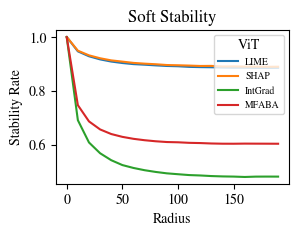

In [19]:
plt.clf()
plt.figure(figsize=(3, 2))
plt.plot(all_radius, lime_stability_rates.cpu().mean(dim=0).numpy(), label="LIME")
plt.plot(all_radius, shap_stability_rates.cpu().mean(dim=0).numpy(), label="SHAP")
plt.plot(all_radius, intgrad_stability_rates.cpu().mean(dim=0).numpy(), label="IntGrad")
plt.plot(all_radius, mfaba_stability_rates.cpu().mean(dim=0).numpy(), label="MFABA")
plt.xlabel('Radius')
plt.ylabel('Stability Rate')
plt.legend(title="ViT", loc="upper right", prop={'size': 7})
plt.title('Soft Stability')
plt.savefig('_dump/vit_imagenet_ssg_1k', bbox_inches="tight")
plt.show()


## As a comparison, here are the certified radii when old-MuS uses lambda=0.25

In [20]:
cert_mus_vit = CertifiedMuSImageClassifier(raw_vit, lambda_=0.25)

In [21]:
cert_lime_stability_rates = torch.cat([
    cert_mus_vit(img.unsqueeze(0).to(device), alpha=exp.unsqueeze(0).to(device))["cert_rs"]
    for img, exp in tqdm(zip(images, lime_explanations), total=len(images))
], dim=0).cpu()

cert_shap_stability_rates = torch.cat([
    cert_mus_vit(img.unsqueeze(0).to(device), alpha=exp.unsqueeze(0).to(device))["cert_rs"]
    for img, exp in tqdm(zip(images, shap_explanations), total=len(images))
], dim=0).cpu()

cert_intgrad_stability_rates = torch.cat([
    cert_mus_vit(img.unsqueeze(0).to(device), alpha=exp.unsqueeze(0).to(device))["cert_rs"]
    for img, exp in tqdm(zip(images, intgrad_explanations), total=len(images))
], dim=0).cpu()

cert_mfaba_stability_rates = torch.cat([
    cert_mus_vit(img.unsqueeze(0).to(device), alpha=exp.unsqueeze(0).to(device))["cert_rs"]
    for img, exp in tqdm(zip(images, mfaba_explanations), total=len(images))
], dim=0).cpu()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [22]:
torch.save(cert_lime_stability_rates, cache_dir / "vit_lime_cert_stability_rates.pt")
torch.save(cert_shap_stability_rates, cache_dir / "vit_shap_cert_stability_rates.pt")
torch.save(cert_intgrad_stability_rates, cache_dir / "vit_intgrad_cert_stability_rates.pt")
torch.save(cert_mfaba_stability_rates, cache_dir / "vit_mfaba_cert_stability_rates.pt")

In [23]:
cert_lime_stability_rates = torch.load(cache_dir / "vit_lime_cert_stability_rates.pt")
cert_shap_stability_rates = torch.load(cache_dir / "vit_shap_cert_stability_rates.pt")
cert_intgrad_stability_rates = torch.load(cache_dir / "vit_intgrad_cert_stability_rates.pt")
cert_mfaba_stability_rates = torch.load(cache_dir / "vit_mfaba_cert_stability_rates.pt")

<Figure size 640x480 with 0 Axes>

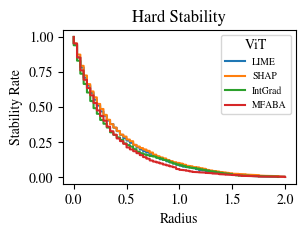

In [24]:
plt.clf()
plt.figure(figsize=(3, 2))
plt.plot(cert_lime_stability_rates.sort(descending=True).values, [0.001 * i for i in range(0, 1000)], label="LIME")
plt.plot(cert_shap_stability_rates.sort(descending=True).values, [0.001 * i for i in range(0, 1000)], label="SHAP")
plt.plot(cert_intgrad_stability_rates.sort(descending=True).values, [0.001 * i for i in range(0, 1000)], label="IntGrad")
plt.plot(cert_mfaba_stability_rates.sort(descending=True).values, [0.001 * i for i in range(0, 1000)], label="MFABA")
plt.xlabel('Radius')
plt.ylabel('Stability Rate')
plt.legend(title="ViT", loc="upper right", prop={'size': 7})
plt.title('Hard Stability')
plt.savefig('_dump/vit_imagenet_hard_1k', bbox_inches="tight")


## Combine soft and hard stability in the same plot

<Figure size 640x480 with 0 Axes>

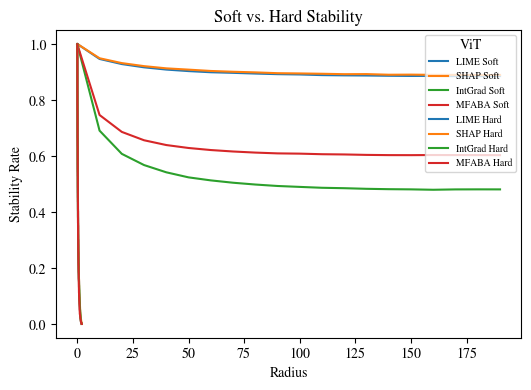

In [25]:
plt.clf()
plt.figure(figsize=(6, 4))
plt.plot(all_radius, lime_stability_rates.cpu().mean(dim=0).numpy(), label="LIME Soft")
plt.plot(all_radius, shap_stability_rates.cpu().mean(dim=0).numpy(), label="SHAP Soft")
plt.plot(all_radius, intgrad_stability_rates.cpu().mean(dim=0).numpy(), label="IntGrad Soft")
plt.plot(all_radius, mfaba_stability_rates.cpu().mean(dim=0).numpy(), label="MFABA Soft")

plt.plot(cert_lime_stability_rates.sort(descending=True).values, [0.001 * i for i in range(0, len(images))], label="LIME Hard", color="#1f77b4")
plt.plot(cert_shap_stability_rates.sort(descending=True).values, [0.001 * i for i in range(0, len(images))], label="SHAP Hard", color="#ff7f0e")
plt.plot(cert_intgrad_stability_rates.sort(descending=True).values, [0.001 * i for i in range(0, len(images))], label="IntGrad Hard", color="#2ca02c")
plt.plot(cert_mfaba_stability_rates.sort(descending=True).values, [0.001 * i for i in range(0, len(images))], label="MFABA Hard", color="#d62728")
plt.xlabel('Radius')
plt.ylabel('Stability Rate')
plt.legend(title="ViT", loc="upper right", prop={'size': 7})
plt.title('Soft vs. Hard Stability')
plt.savefig('_dump/vit_imagenet_softvhard_1k', bbox_inches="tight")
